# 排序點來識別聚類結構(Ordering Points to identify the clustering structure)

##### 先引入我們需要的packages

In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# MNIST Dataset

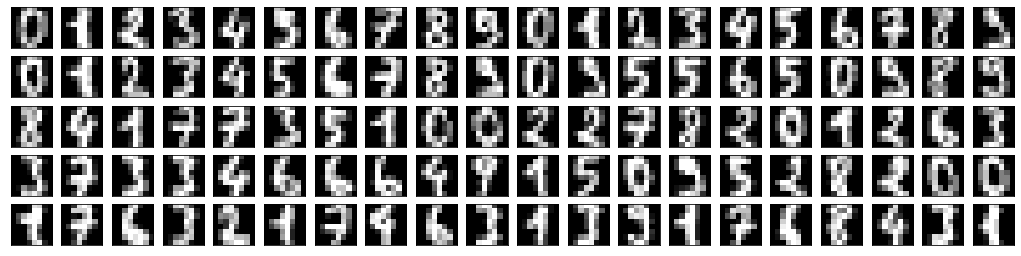

In [2]:
from sklearn.datasets import load_digits
digits = load_digits()
X=(digits.data/16)
y=digits.target
plt.rcParams["figure.figsize"] = (18,18)
plt.gray() 
for i in range(100):
    plt.subplot(20, 20, i + 1)
    plt.imshow(digits.images[i], cmap=plt.cm.gray, vmax=16, interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.show() 

# Principal Component Anlysis

In [3]:
def PCA(X,n_components,N):
    X_center=X-np.mean(X,axis=0)
    W,D,V=np.linalg.svd(X_center.T)
    X_embedded=np.dot(X_center,W[:,:n_components])
    return X_embedded

# Radius Nearest Neighbor

In [4]:
def RadiusNN(i_dist,eps):
    return np.array(np.where(i_dist<=eps)).flatten()

# Set Core Distance

In [5]:
def setCoreDistance(NN_index,i_dist,MinPts):
    if(len(NN_index)<MinPts):
        return -1
    else:
        return (np.sort(i_dist[NN_index]))[MinPts-1]

# Next Index

In [6]:
def next_index(seeds,check_list):
    check=0
    for p in seeds:
        if(check_list[p]==0):
            return p
    return -1

# Insert to Seeds

In [7]:
def insert_seeds(seeds,j,reach_dist):
    if(len(seeds)==0):
        seeds.extend([j])
    else:
        tmp=np.array(np.where(reach_dist[seeds]<reach_dist[j])).flatten()
        if(len(tmp)==0):
            seeds=np.insert(seeds,0,j)
        else:
            insert_index=max(np.array(np.where(reach_dist[seeds]<reach_dist[j])).flatten())
            seeds=np.insert(seeds,insert_index+1,j)
    return seeds

# Decrease in Seeds

In [8]:
def decrease_seeds(seeds,j,reach_dist):
    delete_index=np.array(np.where(seeds==j)).flatten()
    seeds=np.delete(seeds,delete_index)
    tmp=np.array(np.where(reach_dist[seeds]<reach_dist[j])).flatten()
    if(len(tmp)==0):
        seeds=np.insert(seeds,0,j)
    else:
        insert_index=max(np.array(np.where(reach_dist[seeds]<reach_dist[j])).flatten())
        seeds=np.insert(seeds,insert_index+1,j)
    return seeds

# Update

In [9]:
def update(i,NN_index,check_list,seeds,dist,reach_dist,core_dist):
    c_dist=core_dist[i]
    for j in NN_index:
        if(check_list[j]==0):
            new_reach_dist=np.maximum(c_dist,dist[i,j])
            if(reach_dist[j]<0):
                reach_dist[j]=new_reach_dist
                seeds=insert_seeds(seeds,j,reach_dist)
            else:
                if(new_reach_dist<reach_dist[j]):
                    reach_dist[j]=new_reach_dist
                    seeds=decrease_seeds(seeds,j,reach_dist)
    return seeds,reach_dist

# OPTICS

In [10]:
from scipy.spatial.distance import cdist
N,M=X.shape
eps=1.2
MinPts=3
cluster=np.ones(N,dtype=int)*-1
check_list=np.zeros(N,dtype=int)
dist = cdist(X,X,"euclidean")
reach_dist=np.ones(N)*-1
core_dist=np.ones(N)
C=0
for i in range(N):
    if(check_list[i]!=0):
        continue
    check_list[i]=1
    cluster[i]=C
    NN_index=RadiusNN(dist[i],eps)
    core_dist[i]=setCoreDistance(NN_index,dist[i],MinPts)
    if(core_dist[i]>=0):
        seeds,reach_dist=update(i,NN_index,check_list,[],dist,reach_dist,core_dist)
        seeds=list(seeds)
        num=0
        while(len(seeds)>0):
            k=next_index(seeds,check_list)
            if(k==-1):
                break
            new_NN_index=RadiusNN(dist[k],eps)
            check_list[k]=1
            core_dist[k]=setCoreDistance(new_NN_index,dist[k],MinPts)
            cluster[k]=C
            if(core_dist[k]>=0):
                seeds,reach_dist=update(k,new_NN_index,check_list,seeds,dist,reach_dist,core_dist)
            num+=1
            if(num>N):
                print("fucking")
                break    
        C+=1
print(cluster)

[ 0  1  1 ... 39 39 39]


# Number of Points for each Cluster

In [11]:
for i in range(0,max(cluster)+1):
    print("the cluster",i,"contains",np.sum(cluster==i),"data points")

the cluster 0 contains 166 data points
the cluster 1 contains 121 data points
the cluster 2 contains 165 data points
the cluster 3 contains 61 data points
the cluster 4 contains 141 data points
the cluster 5 contains 117 data points
the cluster 6 contains 87 data points
the cluster 7 contains 122 data points
the cluster 8 contains 3 data points
the cluster 9 contains 59 data points
the cluster 10 contains 108 data points
the cluster 11 contains 59 data points
the cluster 12 contains 21 data points
the cluster 13 contains 8 data points
the cluster 14 contains 11 data points
the cluster 15 contains 26 data points
the cluster 16 contains 21 data points
the cluster 17 contains 21 data points
the cluster 18 contains 3 data points
the cluster 19 contains 13 data points
the cluster 20 contains 8 data points
the cluster 21 contains 5 data points
the cluster 22 contains 34 data points
the cluster 23 contains 7 data points
the cluster 24 contains 28 data points
the cluster 25 contains 7 data poi

# Plot

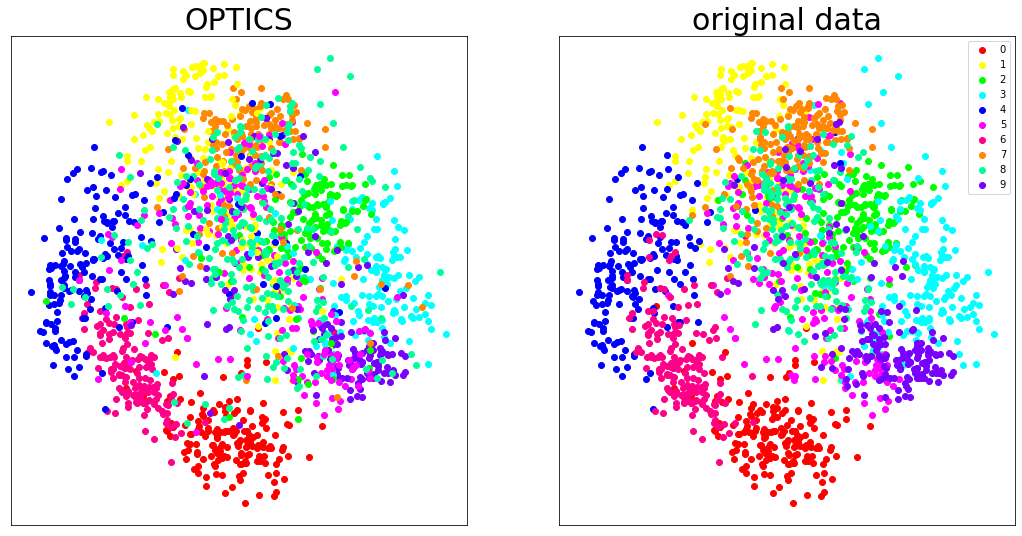

In [12]:
X_embedded=PCA(X,2,N)
color=["#FF0000","#FFFF00","#00FF00","#00FFFF","#0000FF",
       "#FF00FF","#FF0088","#FF8800","#00FF99","#7700FF","#000000"]
plt.rcParams["figure.figsize"] = (18,9)
fig , ax = plt.subplots()
plt.subplot(1, 2, 1)
for i in range(0,max(cluster)+1):
    BOOL=(cluster==i)
    j=np.argmax(np.bincount(y[BOOL]))
    plt.scatter(X_embedded[BOOL,0],X_embedded[BOOL,1],c=color[j])
plt.title("OPTICS",fontsize=30)
plt.xticks([])
plt.yticks([])
plt.subplot(1, 2, 2)
for i in range(0,10):
    plt.scatter(X_embedded[(y==i),0],X_embedded[(y==i),1],c=color[i],label=i)
plt.title("original data",fontsize=30)
plt.xticks([])
plt.yticks([])
plt.legend(fontsize=10)
plt.show()